In [13]:
# Bibliothek für mehr-D Daten (speziell für NetCDF-Daten; Zeit, geografische Koordinaten, ...)
import xarray as xr
import dask
import dask.array as da

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress

from read_sst import load_sst_data


In [14]:
## Auswahl der Daten
# ? https://cds.climate.copernicus.eu/stac-browser/collections/reanalysis-era5-single-levels-monthly-means?.language=en

# xr.open_dataset = Funktion, um Datensatz im NetDCF-Format öffnen
ds_slp = xr.open_dataset(
    "/home/jovyan/my_materials/data/slp_1m.nc",
    # aktiviert Lazy-Loading mit Bibliothek Dask
    # Dask teilt Datensatz in kleinere Chunks auf, die nur bei Bedarf geladen werden in Arbeitsspeicher
    chunks="auto",
)
# Funktion von xarray.Dataset rename
ds_slp = ds_slp.rename_vars(msl="slp")

# Umbennen
ds_slp = ds_slp.rename({'latitude': 'lat', 'longitude': 'lon'})

# Anzahl der gesamten NaN-Werte über lat, lon
#gesamt_nan = slp.isnull().sum(dim="time").sum().values
#print("Gesamtanzahl der NaN-Werte:", gesamt_nan)

## NaN-Werte = 0 -> Ist das korrekt?

# Daten bereinigen (fehlender Wert über Zeit -> Punkt komplett herausnehmen)
#slp = ds_slp['slp']
# Entferne Punkte, bei denen alle Werte über die Zeit NaN sind
#slp_clean = slp.dropna(dim="lat", how="all").dropna(dim="lon", how="all")
# Transponiere zu konsistenten Dimensionen
#slp_clean = slp_clean.transpose("lat", "lon", "time")
# Prüfung der neuen Dimensionen
#print("Bereinigte SLP Shape:", slp_clean.shape)

# auf selbe Gitter wie SST bringen -> lat -90 bis 90, lon -180 bis 180
# -> lat 90 bis -90 auf lat -90 bis 90
ds_slp = ds_slp.sortby('lat')
# -> lon 0 bis 360 auf lon -180 bis 180
ds_slp = ds_slp.assign_coords(lon=(((ds_slp.lon + 180) % 360) - 180))
ds_slp = ds_slp.sortby('lon')
# Transponiere alle Datenvariablen zu lat, lon, time
for var in ds_slp.data_vars:
    ds_slp[var] = ds_slp[var].transpose("lat", "lon", "time") 
# Reorganisiere die Anzeige der Koordinaten
ds_slp = ds_slp.assign_coords(lat=ds_slp['lat'], lon=ds_slp['lon'], time=ds_slp['time'])

# Übersicht des Datensatz wird angezeigt
ds_slp

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 721, lon: 1440, time: 382)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    slp      (lat, lon, time) float32 2GB dask.array<chunksize=(240, 480, 167), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
## Filterzeitraum definieren

start_date = '1999-11-01'
end_date = '2023-12-01'

# Filter anwenden
gefilterte_slp = ds_slp.sel(time=slice(start_date, end_date))

# Gefilterte Daten speichern
output_path = "/home/jovyan/my_materials/data/gefilterte_slp.nc"
gefilterte_slp.to_netcdf(output_path)
print(f"Gefilterte SLP-Daten wurden in {output_path} gespeichert.")

gefilterte_slp

Gefilterte SLP-Daten wurden in /home/jovyan/my_materials/data/gefilterte_slp.nc gespeichert.


<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 721, lon: 1440, time: 290)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 2kB 1999-11-01 1999-12-01 ... 2023-12-01
Data variables:
    slp      (lat, lon, time) float32 1GB dask.array<chunksize=(240, 480, 85), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
# SST-Daten laden
ds_sst = load_sst_data()

#print("SST Anzahl gültige Punkte:", ds_sst['sst'].notnull().sum().compute().item())
#print("SST Anzahl NaN-Punkte:", ds_sst['sst'].isnull().sum().compute().item())

## gültige Punkte = 64.451.976, ungültige = 26.613.624 -> kann das sein? --> TODO: MASKE ERSTELLEN

# Übersicht
ds_sst

<xarray.Dataset> Size: 364MB
Dimensions:  (lat: 340, lon: 720, time: 372)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 1kB -79.88 -79.38 -78.88 -78.38 ... 88.62 89.12 89.62
  * lon      (lon) float32 3kB -179.9 -179.4 -178.9 -178.4 ... 178.6 179.1 179.6
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    sst      (time, lat, lon) float32 364MB dask.array<chunksize=(266, 243, 517), meta=np.ndarray>

In [5]:
#print("SST Dimensionen vor Transpose:", sst_clean.dims)
#print("SLP Dimensionen vor Transpose:", slp_clean.dims)


# Gemeinsame Maske für SST und SLP
#sst_mask = ds_sst.isnull().all(dim='time')  # NaN-Punkte über die Zeit entfernen

#combined_mask = sst_mask | slp_mask  # Punkte entfernen, die in SST oder SLP NaN enthalten

# Anwenden der gemeinsamen Maske
#sst_clean = ds_sst.where(~combined_mask)
#slp_clean = slp.where(~combined_mask)

# Transponieren für konsistente Dimensionen
#sst_clean = sst_clean.transpose("lat", "lon", "time")
#slp_clean = slp_clean.transpose("lat", "lon", "time")

# Prüfung der Dimensionen
#print("Bereinigte SST Shape:", sst_clean.shape)
#print("Bereinigte SLP Shape:", slp_clean.shape)

In [6]:
## Regionen festlegen

# Region 40S definieren (nächstgelegene Breite -40)
slp_region_40S = ds_slp.sel(lat=-40, method="nearest")
# Region 65S definieren (nächstgelegene Breite -65)
slp_region_65S = ds_slp.sel(lat=-65, method="nearest")

print(slp_region_40S, "\n", slp_region_65S)

<xarray.Dataset> Size: 2MB
Dimensions:  (lon: 1440, time: 382)
Coordinates:
    lat      float64 8B -40.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    slp      (lon, time) float32 2MB dask.array<chunksize=(480, 167), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1... 
 <xarray.Dataset> Size: 2MB
Dimensions:  (lon: 1440, time: 382)
Coordinates:
    lat      float64 8B -65.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-10-01
Data variables:
    slp    

In [7]:
## zonale Mittel berechnen / Jahr

# berechnet SLP-Durchschnitt für 40S / Jahr (ohne Dimension lon)
slp_40S_yearly_mean = slp_region_40S.groupby('time.year').mean(dim=['lon', 'time'])
# berechnet SLP-Durchschnitt für 65S / Jahr (ohne Dimension lon)
slp_65S_yearly_mean = slp_region_65S.groupby('time.year').mean(dim=['lon', 'time'])

print(slp_40S_yearly_mean, "\n", slp_65S_yearly_mean)

<xarray.Dataset> Size: 392B
Dimensions:  (year: 32)
Coordinates:
    lat      float64 8B -40.0
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-10T11:40 GRIB to CDM+CF via cfgrib-0.9.1... 
 <xarray.Dataset> Size: 392B
Dimensions:  (year: 32)
Coordinates:
    lat      float64 8B -65.0
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range 

In [8]:
# eindeutigen Namen für Dimension year, da SST auch reingeladen wurde (ausgelagert, da nur 1x ausführen)
ds_slp = ds_slp.rename({'year': 'slp_year'})
# ds_sst = ds_sst.rename({'year': 'sst_year'})



ValueError: cannot rename 'year' because it is not a variable or dimension in this dataset

In [17]:
## Differenz beider Regionen berechnen

slp_diff_yearly = slp_40S_yearly_mean - slp_65S_yearly_mean

print(slp_diff_yearly)

# Konvertiere slp_diff_yearly in ein DataArray
if isinstance(slp_diff_yearly, xr.Dataset):
    slp_diff_yearly = slp_diff_yearly.to_array().squeeze()
else:
    slp_diff_yearly = slp_diff_yearly.squeeze()


# Variable slp_diff_yearly zum Dataset hinzufügen
ds_slp['slp_diff_yearly'] = slp_diff_yearly

<xarray.Dataset> Size: 384B
Dimensions:  (year: 32)
Coordinates:
  * year     (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
Data variables:
    slp      (year) float32 128B dask.array<chunksize=(1,), meta=np.ndarray>


In [18]:
## Normierung

# Mittelwert von jährlicher Differenz berechnen
slp_diff_mean = ds_slp['slp_diff_yearly'].mean().compute()

# Standardabweichung von jährlicher Differenz berechnen
slp_diff_std = ds_slp['slp_diff_yearly'].std().compute()

# SAM-Index berechnen (Transformation der Daten in z-Scores, sodass Std = 1 und Mean = 0)
sam_index= (ds_slp['slp_diff_yearly'] - slp_diff_mean) / slp_diff_std

print(sam_index.mean().compute()) # Mean = 0
print(sam_index.std().compute()) # Std = 1

print(sam_index)

<xarray.DataArray 'slp_diff_yearly' ()> Size: 4B
array(-2.9802322e-08, dtype=float32)
Coordinates:
    variable  <U3 12B 'slp'
<xarray.DataArray 'slp_diff_yearly' ()> Size: 4B
array(1., dtype=float32)
Coordinates:
    variable  <U3 12B 'slp'
<xarray.DataArray 'slp_diff_yearly' (year: 32)> Size: 128B
dask.array<truediv, shape=(32,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year      (year) int64 256B 1993 1994 1995 1996 1997 ... 2021 2022 2023 2024
    variable  <U3 12B 'slp'


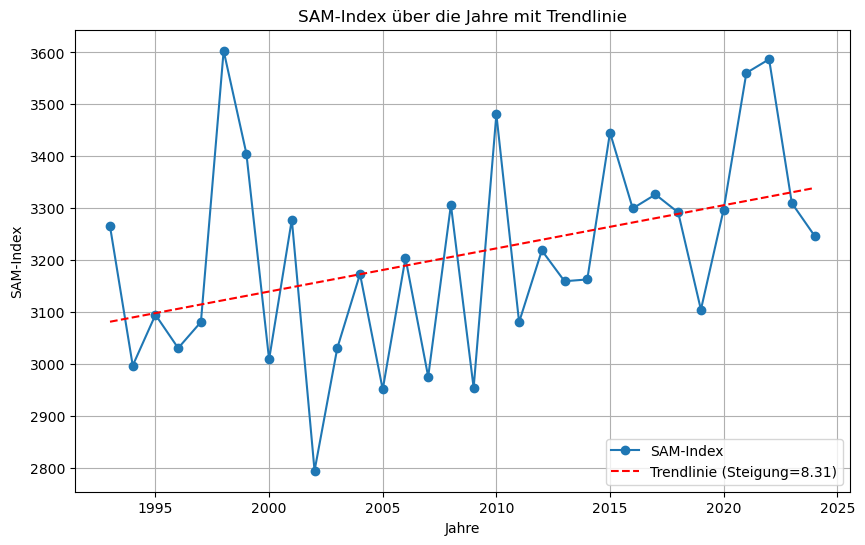

In [19]:
## Plotten SAM-Index über Jahre
# ! Vergleich mit Figure 1 (a) aus Paper 1: 1_Recent trends in the Southern Ocean eddy field --> nicht ganz passend -> ausreichend?

# Zeitkoordinate und SAM-Index-Werte extrahieren
jahre = sam_index['year'].values  # Zeitkoordinate
sam_values = ds_slp['slp_diff_yearly'].values  # SAM-Index-Werte

# Berechnung der Trendlinie (Lineare Regression)
slope, intercept, r_value, p_value, std_err = linregress(jahre, sam_values)
trendline = slope * jahre + intercept

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(jahre, sam_values, label='SAM-Index', linestyle='-', marker='o')
plt.plot(jahre, trendline, label=f'Trendlinie (Steigung={slope:.2f})', color='red', linestyle='--')

# Plot-Details hinzufügen
plt.xlabel('Jahre')
plt.ylabel('SAM-Index')
plt.title('SAM-Index über die Jahre mit Trendlinie')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
## Einheitsvektoranalyse

In [ ]:
# 1. Daten vorbereiten 
# 1.1 Anomalien berechnen, zeitlicher Mittelwert entfernen und normalisieren

# Berechnung der SST-Anomalien
sst_time_mean = ds_sst['sst'].mean(dim='time')
sst_time_std = ds_sst['sst'].std(dim='time')
sst_anomaly = (ds_sst['sst'] - sst_time_mean) / sst_time_std  # Normierte SST-Anomalien

# Berechnung der SLP-Anomalien
slp_time_mean = ds_slp['slp'].mean(dim='time')
slp_time_std = ds_slp['slp'].std(dim='time')
slp_anomaly = (ds_slp['slp'] - slp_time_mean) / slp_time_std  # Normierte SLP-Anomalien

# Speichern der Anomalien
ds_sst['sst_anomaly'] = sst_anomaly
ds_slp['slp_anomaly'] = slp_anomaly

# Prüfung der Ergebnisse
print("SST-Anomalien:", ds_sst['sst_anomaly'])
print("SLP-Anomalien:", ds_slp['slp_anomaly'])



In [ ]:
# 1.2 Gitter und Dimensionen anpassen

# Interpolation der SST-Anomalien auf das SLP-Gitter
sst_anomaly = sst_anomaly.interp(lat=ds_slp['lat'], lon=ds_slp['lon'])

# Prüfung
print("Interpolierte SST-Anomalie Shape:", sst_anomaly.shape)

# Transponiere die Daten zu lat, lon, time
sst_anomaly = sst_anomaly.transpose("lat", "lon", "time")
slp_anomaly = ds_slp['slp_anomaly'].transpose("lat", "lon", "time")

# Zeit und Raum angleichen (falls nötig)
sst_anomaly, slp_anomaly = xr.align(sst_anomaly, slp_anomaly, join="inner")

# Prüfung der Dimensionen
print("SST-Anomalie Shape:", sst_anomaly.shape)
print("SLP-Anomalie Shape:", slp_anomaly.shape)


In [ ]:
# 2. SVD direkt auf Daten durchführen
# 2.1 Anomalien in 2D-Matrizen umformen

# SST- und SLP-Anomalien in Dask-Arrays umformen und "flatten" (lazy loading)
sst_2d = sst_anomaly.stack(space=("lat", "lon")).transpose("time", "space").data
slp_2d = slp_anomaly.stack(space=("lat", "lon")).transpose("time", "space").data

# Formen prüfen
print("SST 2D Shape:", sst_2d.shape)
print("SLP 2D Shape:", slp_2d.shape)


In [ ]:
# 2.2 SVD direkt auf SST und SLP ausführen

# SST- und SLP-Anomalien in Dask-Arrays umformen und Chunking entlang der Zeitachse anpassen
sst_2d = sst_anomaly.stack(space=("lat", "lon")).transpose("time", "space").data.rechunk((100, -1))
slp_2d = slp_anomaly.stack(space=("lat", "lon")).transpose("time", "space").data.rechunk((100, -1))

# Formen prüfen
print("SST 2D Shape:", sst_2d.shape)
print("SLP 2D Shape:", slp_2d.shape)

# SVD durchführen mit Dask (Speicherschonende Variante)
U_sst, Sigma_sst, VT_sst = da.linalg.svd_compressed(sst_2d, k=5)  # k = Anzahl der Singulärwerte
U_slp, Sigma_slp, VT_slp = da.linalg.svd_compressed(slp_2d, k=5)

# Ergebnisse berechnen
U_sst, Sigma_sst, VT_sst = da.compute(U_sst, Sigma_sst, VT_sst)
U_slp, Sigma_slp, VT_slp = da.compute(U_slp, Sigma_slp, VT_slp)

# Prüfung der Ergebnisse
print("SST U Shape:", U_sst.shape)
print("SST Sigma Shape:", Sigma_sst.shape)
print("SST VT Shape:", VT_sst.shape)

print("SLP U Shape:", U_slp.shape)
print("SLP Sigma Shape:", Sigma_slp.shape)
print("SLP VT Shape:", VT_slp.shape)



In [ ]:
# 3. Interpretation und Visualisierung der Muster

